## Notebook for kaggle competition -> Titanic - Machine Learning from Disaster
### Solution author -> Danuk Sanujaya Udagama

In [1]:
# Import all the libraries used for the challenge
# Importing libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from tabulate import tabulate
from sklearn.linear_model import Perceptron
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelBinarizer
from sklearn.ensemble import GradientBoostingClassifier
from IPython.display import display
from collections import Counter
import re

/usr/local/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Import the data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [3]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [4]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Filling the Nan data

#### 1. Filling the Age category

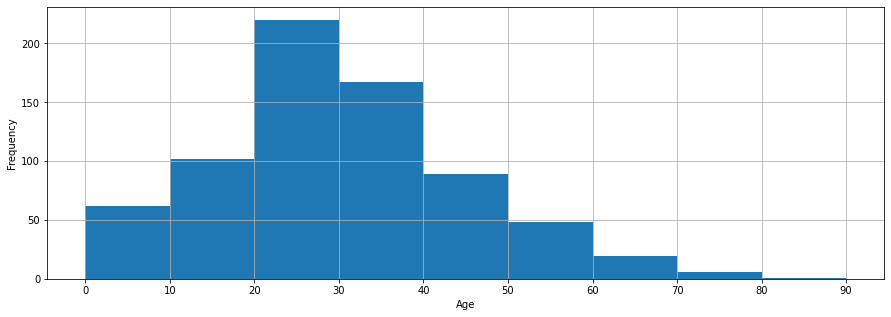

In [5]:
# The age category
figure = plt.figure(figsize=(15,5))
binEdges = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90]
counts, _ = np.histogram(train["Age"].dropna().values, bins=binEdges)
plt.hist(binEdges[:-1], binEdges, weights=counts)
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.grid(True)
plt.xticks(binEdges)
plt.show()

The data seems to be skewed towards 20-30.

In [6]:
print("The mean of the data: ", np.mean(train["Age"].dropna().values))
print("The median of the data: ", np.median(train["Age"].dropna().values))

The mean of the data:  29.69911764705882
The median of the data:  28.0


Both mean and median are suitable for filling the Nan values, lets simply choose the median

In [7]:
train["Age"] = train["Age"].fillna(np.median(train["Age"].dropna().values))
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


#### 2. Filling the cabin category
Hypothesis:
Possible correlations:
  * Fare and cabin letter
  * Sex and cabin letter
  * Class and cabin letter
  * Family aboard and cabin letter

In [8]:
# Converting the existing cabin column to just hold the letter
train["Cabin"] = train["Cabin"].str[0]
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,28.0,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C,C


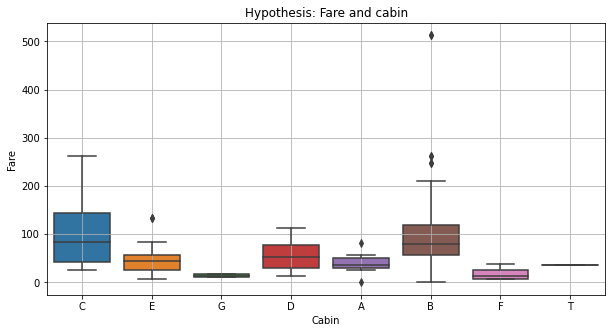

In [9]:
# Take the data with Cabin letters and identify its correlation with other fields
fareCabinHypothesis = train[["Fare" , "Cabin"]]
fareCabinHypothesis = fareCabinHypothesis.dropna()

# Get all the unique cabin letters there are (if there were cabins which are not represented by the training data, that whill be missed)
# cabins = fareCabinHypothesis['Cabin'].unique().tolist()

plt.figure(figsize=(10,5))
sns.boxplot(x='Cabin', y='Fare', data=fareCabinHypothesis)
plt.title("Hypothesis: Fare and cabin")
plt.xlabel('Cabin')
plt.ylabel('Fare')
plt.grid(True)
plt.show()

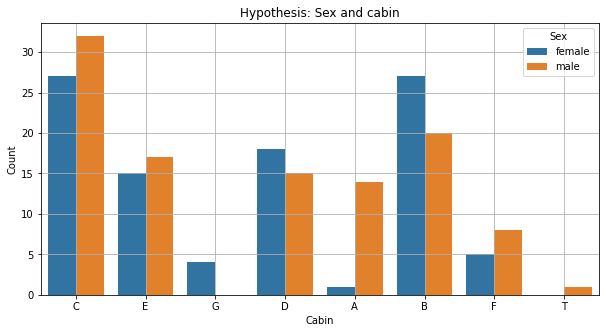

In [10]:
# Take the data with Cabin letters and identify its correlation with other fields
sexCabinHypothesis = train[["Sex" , "Cabin"]]
sexCabinHypothesis = sexCabinHypothesis.dropna()

plt.figure(figsize=(10,5))
sns.countplot(x='Cabin', hue='Sex', data=sexCabinHypothesis)
plt.xlabel('Cabin')
plt.ylabel('Count')
plt.legend(title='Sex')
plt.title("Hypothesis: Sex and cabin")
plt.grid(True)
plt.show()

Important information - Cabin G was female only and cabin T was male only. Cabin A had majority male passengers whereas the other cabins had a mix of both

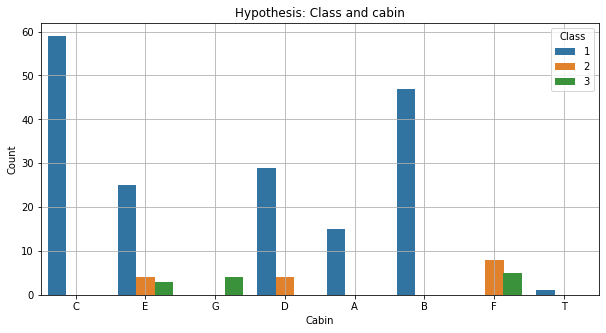

In [11]:
# Take the data with Cabin letters and identify its correlation with other fields
classCabinHypothesis = train[["Pclass" , "Cabin"]]
classCabinHypothesis = classCabinHypothesis.dropna()


plt.figure(figsize=(10,5))
sns.countplot(x='Cabin', hue='Pclass', data=classCabinHypothesis)
plt.xlabel('Cabin')
plt.ylabel('Count')
plt.legend(title='Class')
plt.title("Hypothesis: Class and cabin")
plt.grid(True)
plt.show()

The above plot shows a clear correlation between the class and the cabin they were in. Cabins C, A, T and B were exclusive to first class passengers whilst 3rd class passengers had exclusivity to G. 2nd class passengers were able to take E, D and F. Possible further correlation is Class and fare for predicting the cabin.

Calculte the total family the passenger had (SibSp + Parch). We can use this data for predicting the survivability as well.

In [12]:
# Add new column to the data showing the total number of family the person had aboard the titanic
train["Family"] = train["Parch"] + train["SibSp"]
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,C,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C,S,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,0
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B,S,0
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,28.0,1,2,W./C. 6607,23.4500,NaN,S,3
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C,C,0


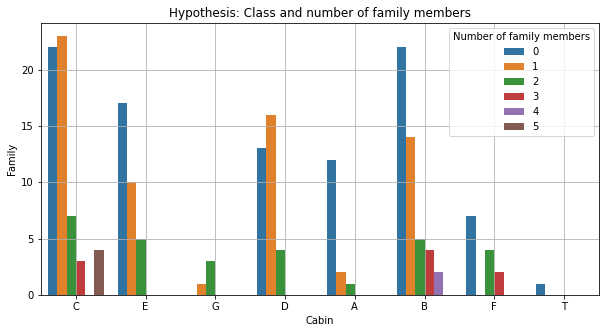

In [13]:
# Identify the relationship between the family size and the cabin they were in
familyCabinHypothesis = train[["Family" , "Cabin"]]
familyCabinHypothesis = familyCabinHypothesis.dropna()

plt.figure(figsize=(10,5))
sns.countplot(x='Cabin', hue='Family', data=familyCabinHypothesis)
plt.xlabel('Cabin')
plt.ylabel('Family')
plt.legend(title='Number of family members')
plt.title("Hypothesis: Class and number of family members")
plt.grid(True)
plt.show()

The data is hard to interpret. Maybe worth looking at people who traveled alone vs who didnt. (Reference -> https://www.kaggle.com/code/funxexcel/titanic-basic-solution-using-adaboost?scriptVersionId=39702467&cellId=20)

In [14]:
train["Alone"] = 0
train.loc[train["Family"] == 0, 'Alone'] = 1
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family,Alone
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,C,1,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C,S,1,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,1


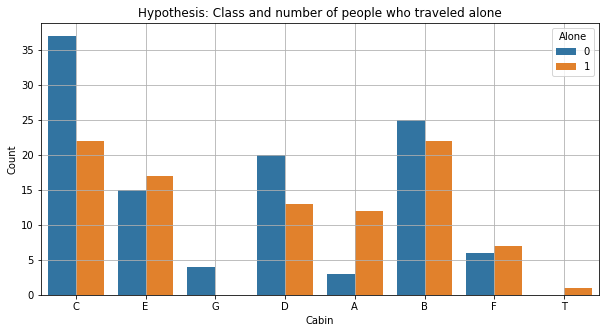

In [15]:
# Take the data with Cabin letters and identify its correlation with other fields
AloneCabinHypothesis = train[["Alone" , "Cabin"]]
AloneCabinHypothesis = AloneCabinHypothesis.dropna()

plt.figure(figsize=(10,5))
sns.countplot(x='Cabin', hue='Alone', data=AloneCabinHypothesis)
plt.xlabel('Cabin')
plt.ylabel('Count')
plt.legend(title='Alone')
plt.title("Hypothesis: Class and number of people who traveled alone")
plt.grid(True)
plt.show()

The above plot gives information that Cabin T only had people traveling alone whilst cabin G had people traveling with family.

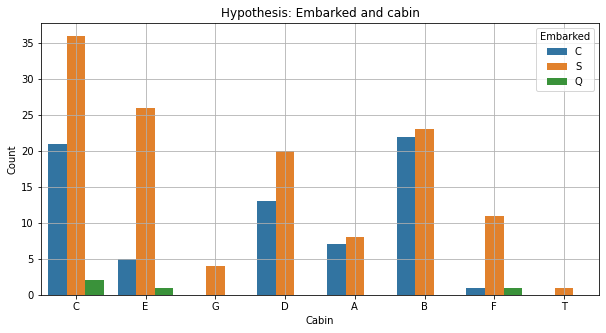

In [16]:
# Take the data with Cabin letters and identify its correlation with other fields
EmbarkedCabinHypothesis = train[["Embarked" , "Cabin"]]
EmbarkedCabinHypothesis = EmbarkedCabinHypothesis.dropna()

plt.figure(figsize=(10,5))
sns.countplot(x='Cabin', hue='Embarked', data=EmbarkedCabinHypothesis)
plt.xlabel('Cabin')
plt.ylabel('Count')
plt.legend(title='Embarked')
plt.title("Hypothesis: Embarked and cabin")
plt.grid(True)
plt.show()

### Plot all figures togeather for easy visualisation

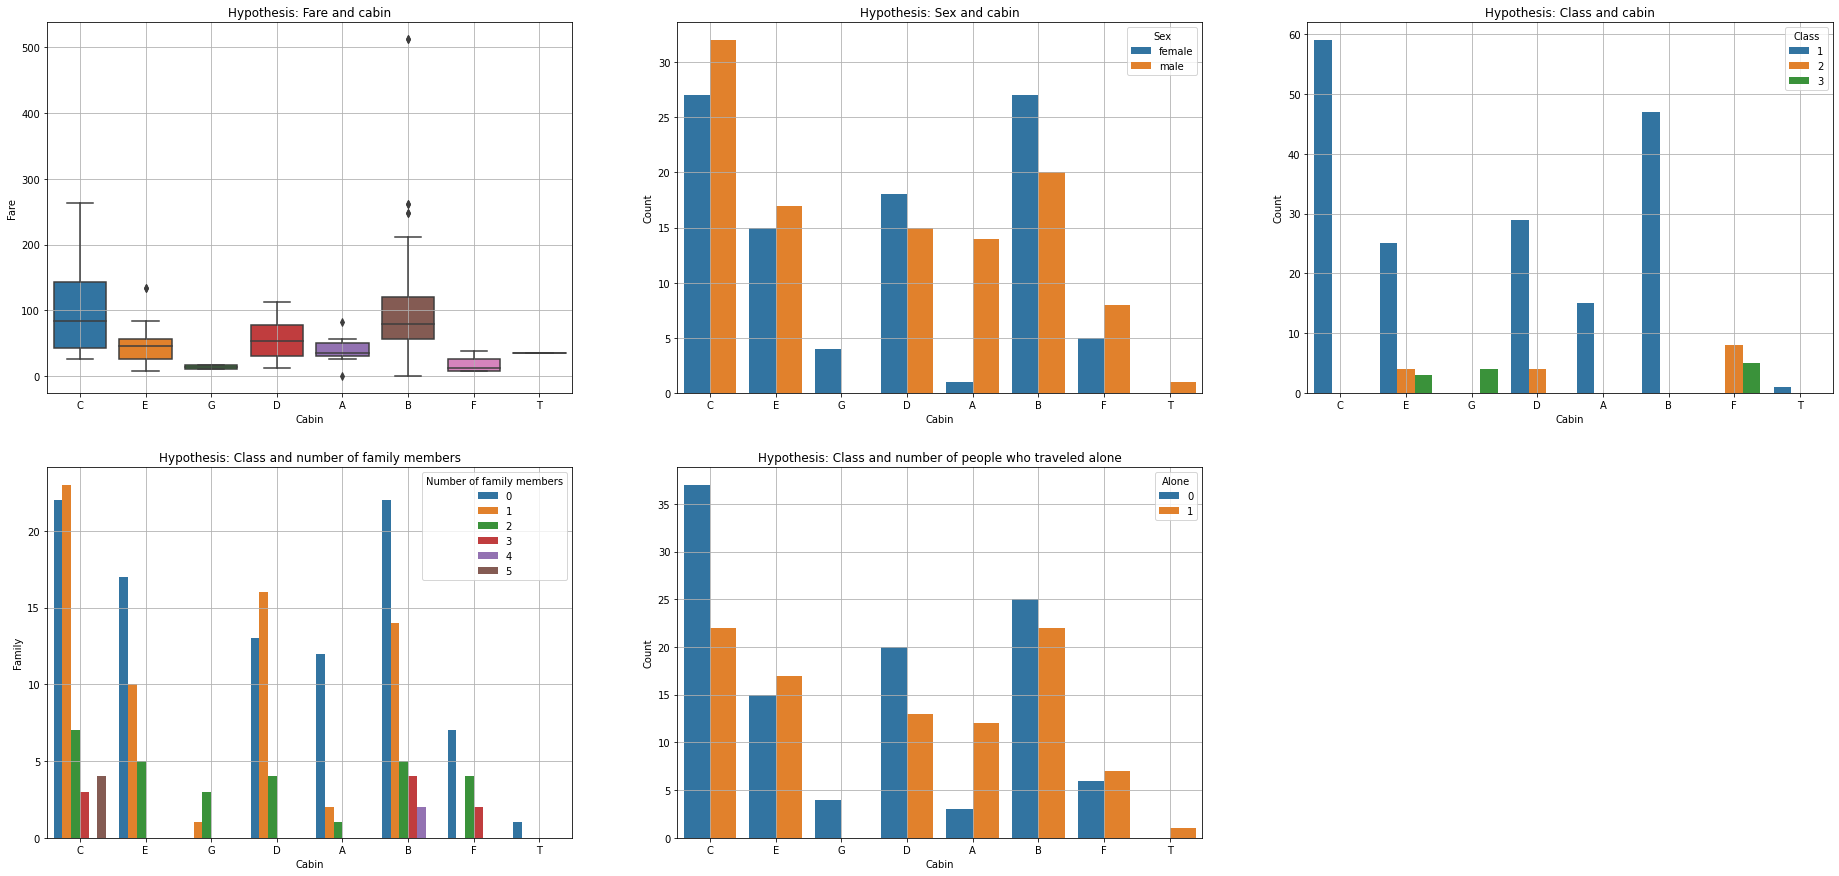

In [17]:
plt.figure(figsize=(32,15))

# Plot 1
plt.subplot(2, 3, 1)
sns.boxplot(x='Cabin', y='Fare', data=fareCabinHypothesis)
plt.title("Hypothesis: Fare and cabin")
plt.xlabel('Cabin')
plt.ylabel('Fare')
plt.grid(True)

# Plot 2
plt.subplot(2, 3, 2)
sns.countplot(x='Cabin', hue='Sex', data=sexCabinHypothesis)
plt.xlabel('Cabin')
plt.ylabel('Count')
plt.legend(title='Sex')
plt.title("Hypothesis: Sex and cabin")
plt.grid(True)

# Plot 3
plt.subplot(2, 3, 3)
sns.countplot(x='Cabin', hue='Pclass', data=classCabinHypothesis)
plt.xlabel('Cabin')
plt.ylabel('Count')
plt.legend(title='Class')
plt.title("Hypothesis: Class and cabin")
plt.grid(True)

# Plot 4
plt.subplot(2, 3, 4)
sns.countplot(x='Cabin', hue='Family', data=familyCabinHypothesis)
plt.xlabel('Cabin')
plt.ylabel('Family')
plt.legend(title='Number of family members')
plt.title("Hypothesis: Class and number of family members")
plt.grid(True)

# Plot 5
plt.subplot(2, 3, 5)
sns.countplot(x='Cabin', hue='Alone', data=AloneCabinHypothesis)
plt.xlabel('Cabin')
plt.ylabel('Count')
plt.legend(title='Alone')
plt.title("Hypothesis: Class and number of people who traveled alone")
plt.grid(True)

plt.show()

Considering all the above information we can make some informative guesses. For instance the class directly impacts which cabin a passenger travelled in, furthermore, there were two carriages where only male or only female passengers travelled in. The fare criteria shows that the carriage G was the chepaest carraige and looking further at the class shows that 3rd class passengers used this cabin. Considering this information along with other correlations the following criteria are suitable for making a model for predicting the class for entries without the class.
* Sex
* Class
* Fare

(Whether they were alone or not can be used however I think this data is mostly the same as class and sex. More specifically the distributions look very similar and I dont believe that we can get any more meaningful extra information out of it)

### Training a small model to predict the passengers cabin

In [18]:
# Get the necessary data for predicting it
fitCabin = train[["Sex", "Pclass", "Fare", "Cabin"]]

# Get only the data which we know the cabin for
fitCabin = fitCabin.dropna()

fitCabinLabels = fitCabin["Cabin"]
# fitCabinLabels = LabelBinarizer().fit_transform(fitCabinLabels)

fitCabin = fitCabin[["Sex", "Pclass", "Fare"]]

# Binarise the sex field
fitCabin = pd.get_dummies(fitCabin, drop_first=True)

fitCabin.head()

,Pclass,Fare,Sex_male
1,1,71.2833,0
3,1,53.1000,0
6,1,51.8625,1
10,3,16.7000,0
11,1,26.5500,0


In [19]:
pipe = Pipeline([('Model', MLPClassifier(max_iter = 10000))])
# Define our parameters for the grid search
params = [{'Model__hidden_layer_sizes': [(50,20)],
           'Model__activation':['logistic','tanh', 'relu'],
           'Model__solver':['adam'],
           'Model__alpha': [0.001, 0.01, 1, 10],
           'Model__learning_rate': ['adaptive']}
          ]
clfMLP = GridSearchCV(estimator = pipe, param_grid = params, scoring=['accuracy'], refit='accuracy', verbose=2)
# Train and get the best hyper parameters for our model
clfMLP.fit(fitCabin, fitCabinLabels)
bestMLP = clfMLP.best_params_
display(pd.DataFrame(clfMLP.cv_results_))

Fitting 5 folds for each of 12 candidates, totalling 60 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


[CV] END Model__activation=logistic, Model__alpha=0.001, Model__hidden_layer_sizes=(50, 20), Model__learning_rate=adaptive, Model__solver=adam; total time=   3.5s
[CV] END Model__activation=logistic, Model__alpha=0.001, Model__hidden_layer_sizes=(50, 20), Model__learning_rate=adaptive, Model__solver=adam; total time=   0.5s
[CV] END Model__activation=logistic, Model__alpha=0.001, Model__hidden_layer_sizes=(50, 20), Model__learning_rate=adaptive, Model__solver=adam; total time=   1.6s
[CV] END Model__activation=logistic, Model__alpha=0.001, Model__hidden_layer_sizes=(50, 20), Model__learning_rate=adaptive, Model__solver=adam; total time=   2.3s
[CV] END Model__activation=logistic, Model__alpha=0.001, Model__hidden_layer_sizes=(50, 20), Model__learning_rate=adaptive, Model__solver=adam; total time=   1.6s
[CV] END Model__activation=logistic, Model__alpha=0.01, Model__hidden_layer_sizes=(50, 20), Model__learning_rate=adaptive, Model__solver=adam; total time=   2.0s
[CV] END Model__activat

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_Model__activation,param_Model__alpha,param_Model__hidden_layer_sizes,param_Model__learning_rate,param_Model__solver,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy
0,1.897601,0.963251,0.001586,0.000131,logistic,0.001,"(50, 20)",adaptive,adam,"{'Model__activation': 'logistic', 'Model__alph...",0.243902,0.292683,0.341463,0.463415,0.375,0.343293,0.074670,4
1,1.539089,0.430654,0.001430,0.000026,logistic,0.01,"(50, 20)",adaptive,adam,"{'Model__activation': 'logistic', 'Model__alph...",0.243902,0.292683,0.365854,0.365854,0.400,0.333659,0.056938,6
2,0.278383,0.014684,0.001573,0.000229,logistic,1,"(50, 20)",adaptive,adam,"{'Model__activation': 'logistic', 'Model__alph...",0.292683,0.219512,0.268293,0.414634,0.300,0.299024,0.064301,9
3,0.274646,0.048677,0.001527,0.000133,logistic,10,"(50, 20)",adaptive,adam,"{'Model__activation': 'logistic', 'Model__alph...",0.292683,0.292683,0.292683,0.292683,0.275,0.289146,0.007073,11
4,2.455653,0.900282,0.001819,0.000275,tanh,0.001,"(50, 20)",adaptive,adam,"{'Model__activation': 'tanh', 'Model__alpha': ...",0.243902,0.463415,0.439024,0.439024,0.400,0.397073,0.079235,2
5,1.707161,0.286807,0.001782,0.000300,tanh,0.01,"(50, 20)",adaptive,adam,"{'Model__activation': 'tanh', 'Model__alpha': ...",0.268293,0.512195,0.439024,0.439024,0.475,0.426707,0.083713,1
6,0.979888,0.154788,0.001719,0.000273,tanh,1,"(50, 20)",adaptive,adam,"{'Model__activation': 'tanh', 'Model__alpha': ...",0.268293,0.439024,0.243902,0.317073,0.425,0.338659,0.079905,5
7,0.981436,0.076576,0.002163,0.000223,tanh,10,"(50, 20)",adaptive,adam,"{'Model__activation': 'tanh', 'Model__alpha': ...",0.317073,0.219512,0.292683,0.390244,0.275,0.298902,0.055832,10
8,1.215350,0.202904,0.001625,0.000204,relu,0.001,"(50, 20)",adaptive,adam,"{'Model__activation': 'relu', 'Model__alpha': ...",0.317073,0.341463,0.219512,0.341463,0.400,0.323902,0.058909,7
9,1.041804,0.145397,0.001931,0.000233,relu,0.01,"(50, 20)",adaptive,adam,"{'Model__activation': 'relu', 'Model__alpha': ...",0.219512,0.487805,0.268293,0.341463,0.425,0.348415,0.098365,3


In [20]:
pipe = Pipeline([('scale', preprocessing.StandardScaler()), ('Model', RandomForestClassifier())])
# Define our parameters for the grid search
params = [{'Model__criterion': ['gini', 'entropy'],
           'Model__bootstrap':[True]
           }]
clfRandForest = GridSearchCV(estimator = pipe, param_grid = params, scoring=['accuracy'], refit='accuracy', verbose=2)
# Train and get the best hyper parameters for our model
clfRandForest.fit(fitCabin, fitCabinLabels)
bestRandForest = clfRandForest.best_params_
display(pd.DataFrame(clfRandForest.cv_results_))

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] END .......Model__bootstrap=True, Model__criterion=gini; total time=   0.1s


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


[CV] END .......Model__bootstrap=True, Model__criterion=gini; total time=   0.1s
[CV] END .......Model__bootstrap=True, Model__criterion=gini; total time=   0.1s
[CV] END .......Model__bootstrap=True, Model__criterion=gini; total time=   0.1s
[CV] END .......Model__bootstrap=True, Model__criterion=gini; total time=   0.1s
[CV] END ....Model__bootstrap=True, Model__criterion=entropy; total time=   0.1s
[CV] END ....Model__bootstrap=True, Model__criterion=entropy; total time=   0.1s
[CV] END ....Model__bootstrap=True, Model__criterion=entropy; total time=   0.1s
[CV] END ....Model__bootstrap=True, Model__criterion=entropy; total time=   0.1s
[CV] END ....Model__bootstrap=True, Model__criterion=entropy; total time=   0.1s


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_Model__bootstrap,param_Model__criterion,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy
0,0.107726,0.003359,0.010259,0.000398,True,gini,"{'Model__bootstrap': True, 'Model__criterion':...",0.390244,0.731707,0.536585,0.585366,0.55,0.558780,0.109165,1
1,0.108216,0.000631,0.010014,0.000492,True,entropy,"{'Model__bootstrap': True, 'Model__criterion':...",0.390244,0.707317,0.512195,0.585366,0.55,0.549024,0.102904,2


In [21]:
pipe = Pipeline([('scale', preprocessing.StandardScaler()), ('Model', GaussianNB())])
params = [{'scale': [preprocessing.StandardScaler()]}]
clfNaiveBayes = GridSearchCV(estimator = pipe, param_grid = params, n_jobs=-1, scoring=['accuracy'], refit='accuracy', verbose=2)
#Train and get the best hyper parameters for our model
clfNaiveBayes.fit(fitCabin, fitCabinLabels)
bestNiaveBayes = clfNaiveBayes.best_params_
display(pd.DataFrame(clfNaiveBayes.cv_results_))

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/local/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/local/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/local/lib/python3.9/site-packages/scipy/__init__.py:146: U

[CV] END .............................scale=StandardScaler(); total time=   0.0s
[CV] END .............................scale=StandardScaler(); total time=   0.0s
[CV] END .............................scale=StandardScaler(); total time=   0.0s
[CV] END .............................scale=StandardScaler(); total time=   0.0s
[CV] END .............................scale=StandardScaler(); total time=   0.0s


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_scale,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy
0,0.006493,0.001276,0.002973,0.000229,StandardScaler(),{'scale': StandardScaler()},0.292683,0.365854,0.195122,0.341463,0.25,0.289024,0.061655,1


Although the highest accuracy we achieved for the multiclass classification of which cabin a passenger took, we will still have to use this model to predict which cabin the passenger took. We can ultimately check if this hinders the performance by conducting tests with and without the cabin feature.

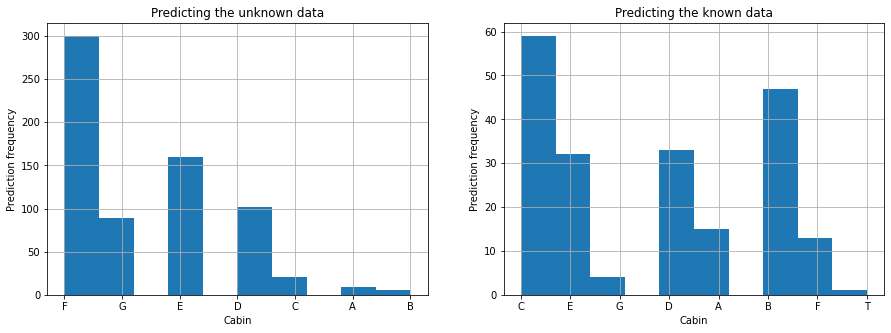

The predicted distribution Counter({'F': 300, 'E': 160, 'D': 102, 'G': 89, 'C': 21, 'A': 9, 'B': 6})
The training distribution Counter({'C': 59, 'B': 47, 'D': 33, 'E': 32, 'A': 15, 'F': 13, 'G': 4, 'T': 1})


In [22]:
# Predict the Nan values
fillCabinNa = train[pd.isna(train["Cabin"])][["Sex", "Pclass", "Fare"]]
fillCabinNa = pd.get_dummies(fillCabinNa, drop_first=True)

# Fill each row by predicting them using the random forest
predctions = clfRandForest.best_estimator_.predict(fillCabinNa)


plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.title("Predicting the unknown data")
plt.hist(predctions)
plt.xlabel("Cabin")
plt.ylabel("Prediction frequency")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.title("Predicting the known data")
plt.hist(train["Cabin"].dropna())
plt.xlabel("Cabin")
plt.ylabel("Prediction frequency")
plt.grid(True)

plt.show()

print("The predicted distribution", Counter(predctions))
print("The training distribution", Counter(train["Cabin"].dropna()))

The above data shows that our method for predicting the cabin may not be very applicable in this instance as the distributions seem to differ greatly. Therefore I believe that using the cabin information in the prediction model may not be very appropriate (THe predicted values for Nan values would be errorneous).

In [23]:
train = train.drop(axis=1, columns=["Cabin"])
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Embarked     889 non-null    object 
 11  Family       891 non-null    int64  
 12  Alone        891 non-null    int64  
dtypes: float64(2), int64(7), object(4)
memory usage: 90.6+ KB


#### 3. Filling the embarked category

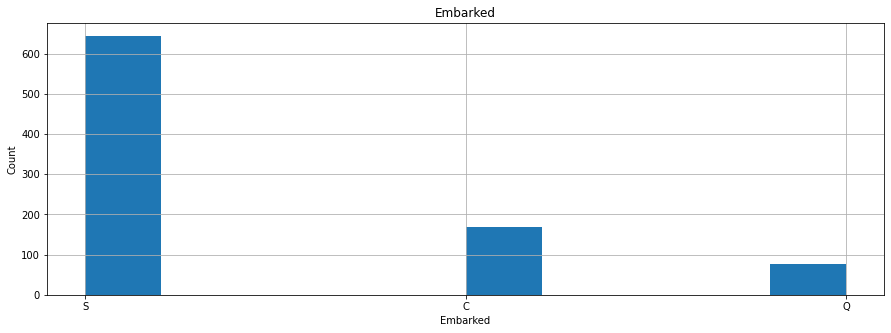

In [24]:
# Visualise the embarked label
plt.figure(figsize=(15, 5))
plt.title("Embarked")
plt.hist(train["Embarked"].dropna())
plt.xlabel("Embarked")
plt.ylabel("Count")
plt.grid(True)
plt.show()

The above data shows that embarking from S is much more common than C and Q. Considering there is only 2 examples with missing Embarked value, we can make a simple assumption that they embarked from S.

In [25]:
train["Embarked"] = train["Embarked"].fillna("S")
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Family,Alone
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,1,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,1,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,1,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,S,0,1
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,S,0,1
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,28.0,1,2,W./C. 6607,23.4500,S,3,0
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C,0,1


Feature engineering: Extracting the honorific from the name of the passenger. This information could prove useful when identifying if an important person was aboard and whether their social status made them survive or not.

Reference - https://www.kaggle.com/code/funxexcel/titanic-basic-solution-using-adaboost?scriptVersionId=39702467&cellId=16
            Introduces the code for this but we will further analyse if this has any correlation with the survivability

In [26]:
train["Name"]

0                                Braund, Mr. Owen Harris
1      Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                 Heikkinen, Miss. Laina
3           Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                               Allen, Mr. William Henry
                             ...                        
886                                Montvila, Rev. Juozas
887                         Graham, Miss. Margaret Edith
888             Johnston, Miss. Catherine Helen "Carrie"
889                                Behr, Mr. Karl Howell
890                                  Dooley, Mr. Patrick
Name: Name, Length: 891, dtype: object

In [27]:
# The regex was extracted from the cell in the above reference
regex = "([A-Za-z]+\.)"
train["Title"] = train["Name"].apply(lambda x : re.search(regex, x).group()[:-1])

# Check if anywhere something went wrong
print("All rows were mapped: ", not any(train["Title"].isna().tolist()))

train["Title"]

All rows were mapped:  True


0        Mr
1       Mrs
2      Miss
3       Mrs
4        Mr
       ... 
886     Rev
887    Miss
888    Miss
889      Mr
890      Mr
Name: Title, Length: 891, dtype: object

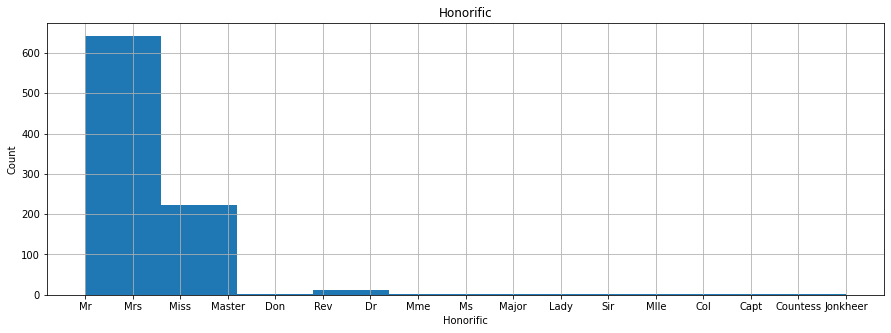

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Mlle          2
Major         2
Col           2
Countess      1
Capt          1
Ms            1
Sir           1
Lady          1
Mme           1
Don           1
Jonkheer      1
Name: Title, dtype: int64


In [28]:
# Understanding the distribution of honorics
plt.figure(figsize=(15, 5))
plt.title("Honorific")
plt.hist(train["Title"])
plt.xlabel("Honorific")
plt.ylabel("Count")
plt.grid(True)
plt.show()

print(train["Title"].value_counts())

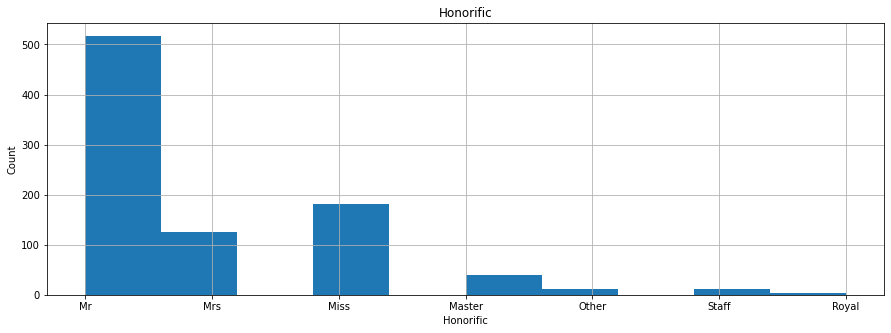

In [29]:
# This feature extraction method is taken directly from the solution on the discussion page
train['Title'] = train['Title'].replace(['Dr', 'Major', 'Col', 'Capt'], 'Staff')
train['Title'] = train['Title'].replace(['Rev', 'Ms', 'Jonkheer', 'Don', 'Mme', 'Mlle', 'Dona'], 'Other')
train['Title'] = train['Title'].replace(['Countess', 'Sir', 'Lady'], 'Royal')

train["Title"].value_counts()

plt.figure(figsize=(15, 5))
plt.title("Honorific")
plt.hist(train["Title"])
plt.xlabel("Honorific")
plt.ylabel("Count")
plt.grid(True)
plt.show()

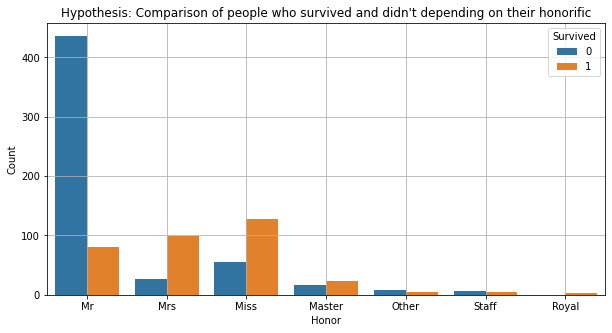

In [30]:
# Take the data with Cabin letters and identify its correlation with other fields
honorSurviveHypothesis = train[["Title" , "Survived"]]

plt.figure(figsize=(10,5))
sns.countplot(x='Title', hue='Survived', data=honorSurviveHypothesis)
plt.xlabel('Honor')
plt.ylabel('Count')
plt.legend(title='Survived')
plt.title("Hypothesis: Comparison of people who survived and didn't depending on their honorific")
plt.grid(True)
plt.show()

In [31]:
xTrain = train.drop(columns=["Survived"])
yTrain = pd.DataFrame(train["Survived"])

xTrain = xTrain.drop(columns=["Name", "PassengerId", "Ticket"])

# Convert into dummy data for training
xTrain = pd.get_dummies(xTrain, drop_first=True)
xTrain

,Pclass,Age,SibSp,Parch,Fare,Family,Alone,Sex_male,Embarked_Q,Embarked_S,Title_Miss,Title_Mr,Title_Mrs,Title_Other,Title_Royal,Title_Staff
0,3,22.0,1,0,7.2500,1,0,1,0,1,0,1,0,0,0,0
1,1,38.0,1,0,71.2833,1,0,0,0,0,0,0,1,0,0,0
2,3,26.0,0,0,7.9250,0,1,0,0,1,1,0,0,0,0,0
3,1,35.0,1,0,53.1000,1,0,0,0,1,0,0,1,0,0,0
4,3,35.0,0,0,8.0500,0,1,1,0,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,2,27.0,0,0,13.0000,0,1,1,0,1,0,0,0,1,0,0
887,1,19.0,0,0,30.0000,0,1,0,0,1,1,0,0,0,0,0
888,3,28.0,1,2,23.4500,3,0,0,0,1,1,0,0,0,0,0
889,1,26.0,0,0,30.0000,0,1,1,0,0,0,1,0,0,0,0


## Training models using the pre-processed data

### 1. Perceptron

In [32]:
pipe = Pipeline([('scale', preprocessing.StandardScaler()), ('Model', Perceptron())])
params = [{'Model__penalty' : ['l2'],
           'Model__alpha' : [0.001, 0.01, 0.1, 0.2, 0.3]}]
clfPerceptron = GridSearchCV(estimator = pipe, param_grid = params, n_jobs=-1, scoring=['average_precision', 'balanced_accuracy', 'roc_auc', 'accuracy', 'f1'], refit='average_precision', verbose=2)
#Train and get the best hyper parameters for our model
clfPerceptron.fit(xTrain, yTrain.values.ravel())
display(pd.DataFrame(clfPerceptron.cv_results_))

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END ..............Model__alpha=0.001, Model__penalty=l2; total time=   0.0s
[CV] END ..............Model__alpha=0.001, Model__penalty=l2; total time=   0.0s
[CV] END ..............Model__alpha=0.001, Model__penalty=l2; total time=   0.0s
[CV] END ...............Model__alpha=0.01, Model__penalty=l2; total time=   0.0s


/usr/local/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/local/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/local/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END ..............Model__alpha=0.001, Model__penalty=l2; total time=   0.0s
[CV] END ...............Model__alpha=0.01, Model__penalty=l2; total time=   0.0s
[CV] END ...............Model__alpha=0.01, Model__penalty=l2; total time=   0.0s
[CV] END ................Model__alpha=0.1, Model__penalty=l2; total time=   0.0s
[CV] END ................Model__alpha=0.1, Model__penalty=l2; total time=   0.0s
[CV] END ................Model__alpha=0.1, Model__penalty=l2; total time=   0.0s
[CV] END ................Model__alpha=0.1, Model__penalty=l2; total time=   0.0s
[CV] END ................Model__alpha=0.2, Model__penalty=l2; total time=   0.0s
[CV] END ................Model__alpha=0.2, Model__penalty=l2; total time=   0.0s
[CV] END ................Model__alpha=0.1, Model__penalty=l2; total time=   0.0s
[CV] END ................Model__alpha=0.2, Model__penalty=l2; total time=   0.0s
[CV] END ................Model__alpha=0.2, Model__penalty=l2; total time=   0.0s
[CV] END ................Mod

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_Model__alpha,param_Model__penalty,params,split0_test_average_precision,split1_test_average_precision,split2_test_average_precision,...,std_test_accuracy,rank_test_accuracy,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1
0,0.008377,0.002754,0.009810,0.001923,0.001,l2,"{'Model__alpha': 0.001, 'Model__penalty': 'l2'}",0.520218,0.743541,0.710664,...,0.060974,1,0.466165,0.718310,0.693878,0.614035,0.580645,0.614607,0.089696,1
1,0.008196,0.002105,0.009964,0.003357,0.01,l2,"{'Model__alpha': 0.01, 'Model__penalty': 'l2'}",0.524248,0.281187,0.738008,...,0.150632,5,0.425197,0.298137,0.733813,0.539683,0.666667,0.532699,0.158126,4
2,0.009940,0.001354,0.011959,0.000959,0.1,l2,"{'Model__alpha': 0.1, 'Model__penalty': 'l2'}",0.462291,0.665242,0.386054,...,0.101415,4,0.268041,0.585366,0.323077,0.437956,0.746667,0.472221,0.175060,5
3,0.008318,0.000236,0.009798,0.001180,0.2,l2,"{'Model__alpha': 0.2, 'Model__penalty': 'l2'}",0.604382,0.303595,0.485356,...,0.126881,3,0.678363,0.186441,0.411765,0.700730,0.736111,0.542682,0.212062,3
4,0.008212,0.000785,0.009965,0.000896,0.3,l2,"{'Model__alpha': 0.3, 'Model__penalty': 'l2'}",0.571416,0.339135,0.739049,...,0.127502,2,0.631068,0.379747,0.735294,0.595041,0.671429,0.602516,0.120728,2


### 2. Gaussian Naive Bayes

In [33]:
pipe = Pipeline([('scale', preprocessing.StandardScaler()), ('Model', GaussianNB())])
params = [{'scale': [preprocessing.StandardScaler()]}]
clfNaiveBayes = GridSearchCV(estimator = pipe, param_grid = params, n_jobs=-1, scoring=['average_precision', 'balanced_accuracy', 'roc_auc', 'accuracy', 'f1'], refit='average_precision', verbose=2)
#Train and get the best hyper parameters for our model
clfNaiveBayes.fit(xTrain, yTrain.values.ravel())
display(pd.DataFrame(clfNaiveBayes.cv_results_))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END .............................scale=StandardScaler(); total time=   0.0s
[CV] END .............................scale=StandardScaler(); total time=   0.0s
[CV] END .............................scale=StandardScaler(); total time=   0.0s
[CV] END .............................scale=StandardScaler(); total time=   0.0s
[CV] END .............................scale=StandardScaler(); total time=   0.0s


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_scale,params,split0_test_average_precision,split1_test_average_precision,split2_test_average_precision,split3_test_average_precision,...,std_test_accuracy,rank_test_accuracy,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1
0,0.007457,0.000464,0.009878,0.00068,StandardScaler(),{'scale': StandardScaler()},0.684974,0.763429,0.682519,0.732673,...,0.027683,1,0.361702,0.367816,0.282353,0.373626,0.483516,0.373803,0.06416,1


### 3. Linear SVM

In [34]:
pipe = Pipeline([('scale', preprocessing.StandardScaler()), ('Model', LinearSVC(max_iter=200000))])
# Define our parameters for the grid search
params = [ {'Model__penalty': ['l2'], 'Model__loss': ['hinge'], 'Model__C': [ 1*10**-2, 1*10**-1, 1, 10, 100]},
          {'scale': [preprocessing.StandardScaler()],
           'Model__penalty': ['l1'], 'Model__loss': ['squared_hinge'], 'Model__dual': [False], 'Model__C': [1*10**-2, 1*10**-1, 1, 10, 100]}]

clfLinearSVM = GridSearchCV(estimator = pipe, param_grid = params, scoring=['average_precision', 'balanced_accuracy', 'roc_auc', 'accuracy', 'f1'], refit='average_precision', verbose=2)
# Train and get the best hyper parameters for our model
clfLinearSVM.fit(xTrain, yTrain.values.ravel())
display(pd.DataFrame(clfLinearSVM.cv_results_))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END Model__C=0.01, Model__loss=hinge, Model__penalty=l2; total time=   0.0s
[CV] END Model__C=0.01, Model__loss=hinge, Model__penalty=l2; total time=   0.0s
[CV] END Model__C=0.01, Model__loss=hinge, Model__penalty=l2; total time=   0.0s
[CV] END Model__C=0.01, Model__loss=hinge, Model__penalty=l2; total time=   0.0s
[CV] END Model__C=0.01, Model__loss=hinge, Model__penalty=l2; total time=   0.0s
[CV] END .Model__C=0.1, Model__loss=hinge, Model__penalty=l2; total time=   0.0s
[CV] END .Model__C=0.1, Model__loss=hinge, Model__penalty=l2; total time=   0.0s
[CV] END .Model__C=0.1, Model__loss=hinge, Model__penalty=l2; total time=   0.0s
[CV] END .Model__C=0.1, Model__loss=hinge, Model__penalty=l2; total time=   0.0s
[CV] END .Model__C=0.1, Model__loss=hinge, Model__penalty=l2; total time=   0.0s
[CV] END ...Model__C=1, Model__loss=hinge, Model__penalty=l2; total time=   0.0s
[CV] END ...Model__C=1, Model__loss=hinge, Model

/usr/local/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ..Model__C=10, Model__loss=hinge, Model__penalty=l2; total time=   0.2s


/usr/local/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ..Model__C=10, Model__loss=hinge, Model__penalty=l2; total time=   0.3s


/usr/local/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ..Model__C=10, Model__loss=hinge, Model__penalty=l2; total time=   0.3s


/usr/local/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ..Model__C=10, Model__loss=hinge, Model__penalty=l2; total time=   0.3s


/usr/local/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ..Model__C=10, Model__loss=hinge, Model__penalty=l2; total time=   0.4s


/usr/local/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END .Model__C=100, Model__loss=hinge, Model__penalty=l2; total time=   0.8s


/usr/local/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END .Model__C=100, Model__loss=hinge, Model__penalty=l2; total time=   0.6s


/usr/local/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END .Model__C=100, Model__loss=hinge, Model__penalty=l2; total time=   0.8s


/usr/local/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END .Model__C=100, Model__loss=hinge, Model__penalty=l2; total time=   0.9s


/usr/local/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END .Model__C=100, Model__loss=hinge, Model__penalty=l2; total time=   1.0s
[CV] END Model__C=0.01, Model__dual=False, Model__loss=squared_hinge, Model__penalty=l1, scale=StandardScaler(); total time=   0.0s
[CV] END Model__C=0.01, Model__dual=False, Model__loss=squared_hinge, Model__penalty=l1, scale=StandardScaler(); total time=   0.0s
[CV] END Model__C=0.01, Model__dual=False, Model__loss=squared_hinge, Model__penalty=l1, scale=StandardScaler(); total time=   0.0s
[CV] END Model__C=0.01, Model__dual=False, Model__loss=squared_hinge, Model__penalty=l1, scale=StandardScaler(); total time=   0.0s
[CV] END Model__C=0.01, Model__dual=False, Model__loss=squared_hinge, Model__penalty=l1, scale=StandardScaler(); total time=   0.0s
[CV] END Model__C=0.1, Model__dual=False, Model__loss=squared_hinge, Model__penalty=l1, scale=StandardScaler(); total time=   0.0s
[CV] END Model__C=0.1, Model__dual=False, Model__loss=squared_hinge, Model__penalty=l1, scale=StandardScaler(); total time=   0.

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_Model__C,param_Model__loss,param_Model__penalty,param_Model__dual,param_scale,params,...,std_test_accuracy,rank_test_accuracy,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1
0,0.005663,0.000527,0.005689,0.000311,0.01,hinge,l2,NaN,NaN,"{'Model__C': 0.01, 'Model__loss': 'hinge', 'Mo...",...,0.020142,10,0.750000,0.740741,0.702290,0.645161,0.708661,0.709371,0.036901,10
1,0.021455,0.006696,0.005408,0.000087,0.1,hinge,l2,NaN,NaN,"{'Model__C': 0.1, 'Model__loss': 'hinge', 'Mod...",...,0.022506,1,0.802920,0.766917,0.744186,0.704918,0.817518,0.767292,0.040538,1
2,0.112329,0.059046,0.005410,0.000205,1,hinge,l2,NaN,NaN,"{'Model__C': 1, 'Model__loss': 'hinge', 'Model...",...,0.020764,2,0.802920,0.757576,0.753846,0.704918,0.808824,0.765617,0.037804,2
3,0.312006,0.044560,0.005751,0.000330,10,hinge,l2,NaN,NaN,"{'Model__C': 10, 'Model__loss': 'hinge', 'Mode...",...,0.023373,8,0.802920,0.757576,0.748092,0.677966,0.800000,0.757311,0.045350,8
4,0.807922,0.139904,0.006068,0.000565,100,hinge,l2,NaN,NaN,"{'Model__C': 100, 'Model__loss': 'hinge', 'Mod...",...,0.021313,3,0.802920,0.757576,0.748092,0.700000,0.808824,0.763482,0.039782,5
5,0.004765,0.000078,0.004874,0.000262,0.01,squared_hinge,l1,False,StandardScaler(),"{'Model__C': 0.01, 'Model__dual': False, 'Mode...",...,0.013335,9,0.755245,0.744526,0.729927,0.687023,0.719424,0.727229,0.023532,9
6,0.007613,0.001050,0.005147,0.000476,0.1,squared_hinge,l1,False,StandardScaler(),"{'Model__C': 0.1, 'Model__dual': False, 'Model...",...,0.026431,4,0.794326,0.757576,0.731343,0.710744,0.829630,0.764724,0.042821,3
7,0.024344,0.008037,0.005715,0.000230,1,squared_hinge,l1,False,StandardScaler(),"{'Model__C': 1, 'Model__dual': False, 'Model__...",...,0.026431,4,0.791367,0.757576,0.736842,0.704918,0.829630,0.764066,0.043187,4
8,0.051150,0.009052,0.007956,0.001421,10,squared_hinge,l1,False,StandardScaler(),"{'Model__C': 10, 'Model__dual': False, 'Model_...",...,0.026016,6,0.785714,0.757576,0.736842,0.704918,0.829630,0.762936,0.042527,6
9,0.055001,0.005900,0.005521,0.000526,100,squared_hinge,l1,False,StandardScaler(),"{'Model__C': 100, 'Model__dual': False, 'Model...",...,0.026016,6,0.785714,0.757576,0.736842,0.704918,0.829630,0.762936,0.042527,6


### 4. Kernalised SVM

In [35]:
pipe = Pipeline([('scale', preprocessing.StandardScaler()), ('Model', SVC())])
# Define our parameters for the grid search
params = [{'scale': [preprocessing.StandardScaler()],
           'Model__C': [1*10**-2, 1*10**-1, 1, 10],
           'Model__kernel': ['linear', 'poly', 'rbf'],
           'Model__gamma':['scale', 'auto'], 'Model__degree': [2, 3], 'Model__coef0': [-1, 1]}]
clfKernalisedSVM = GridSearchCV(estimator = pipe, param_grid = params, scoring=['average_precision', 'balanced_accuracy', 'roc_auc', 'accuracy', 'f1'], refit='average_precision', verbose=2)
# Train and get the best hyper parameters for our model
clfKernalisedSVM.fit(xTrain, yTrain.values.ravel())
display(pd.DataFrame(clfKernalisedSVM.cv_results_))

Fitting 5 folds for each of 96 candidates, totalling 480 fits
[CV] END Model__C=0.01, Model__coef0=-1, Model__degree=2, Model__gamma=scale, Model__kernel=linear, scale=StandardScaler(); total time=   0.0s
[CV] END Model__C=0.01, Model__coef0=-1, Model__degree=2, Model__gamma=scale, Model__kernel=linear, scale=StandardScaler(); total time=   0.0s
[CV] END Model__C=0.01, Model__coef0=-1, Model__degree=2, Model__gamma=scale, Model__kernel=linear, scale=StandardScaler(); total time=   0.0s
[CV] END Model__C=0.01, Model__coef0=-1, Model__degree=2, Model__gamma=scale, Model__kernel=linear, scale=StandardScaler(); total time=   0.0s
[CV] END Model__C=0.01, Model__coef0=-1, Model__degree=2, Model__gamma=scale, Model__kernel=linear, scale=StandardScaler(); total time=   0.0s
[CV] END Model__C=0.01, Model__coef0=-1, Model__degree=2, Model__gamma=scale, Model__kernel=poly, scale=StandardScaler(); total time=   0.0s
[CV] END Model__C=0.01, Model__coef0=-1, Model__degree=2, Model__gamma=scale, Mode

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_Model__C,param_Model__coef0,param_Model__degree,param_Model__gamma,param_Model__kernel,param_scale,...,std_test_accuracy,rank_test_accuracy,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1
0,0.011851,0.000754,0.008554,0.001102,0.01,-1,2,scale,linear,StandardScaler(),...,0.019974,67,0.740741,0.742424,0.702290,0.645161,0.698413,0.705806,0.035514,67
1,0.016372,0.000535,0.009920,0.000484,0.01,-1,2,scale,poly,StandardScaler(),...,0.008094,89,0.000000,0.026667,0.075000,0.050000,0.026316,0.035596,0.025271,87
2,0.018534,0.001276,0.024340,0.000332,0.01,-1,2,scale,rbf,StandardScaler(),...,0.002325,81,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,89
3,0.011608,0.001328,0.007652,0.000491,0.01,-1,2,auto,linear,StandardScaler(),...,0.019974,67,0.740741,0.742424,0.702290,0.645161,0.698413,0.705806,0.035514,67
4,0.016015,0.000461,0.009863,0.000401,0.01,-1,2,auto,poly,StandardScaler(),...,0.008094,89,0.000000,0.026667,0.075000,0.050000,0.026316,0.035596,0.025271,87
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,0.028999,0.003407,0.007855,0.000790,10,1,3,scale,poly,StandardScaler(),...,0.025422,59,0.737705,0.741935,0.736000,0.655462,0.784000,0.731021,0.041724,59
92,0.018448,0.001604,0.016215,0.000221,10,1,3,scale,rbf,StandardScaler(),...,0.027251,51,0.725806,0.747967,0.771654,0.650000,0.764228,0.731931,0.043882,51
93,0.073992,0.007873,0.007110,0.000295,10,1,3,auto,linear,StandardScaler(),...,0.019831,23,0.802920,0.757576,0.748092,0.710744,0.808824,0.765631,0.036445,23
94,0.029416,0.003649,0.007970,0.000427,10,1,3,auto,poly,StandardScaler(),...,0.025422,59,0.737705,0.741935,0.736000,0.655462,0.784000,0.731021,0.041724,59


### 5. Multilayer perceptron

In [36]:
pipe = Pipeline([('scale', preprocessing.StandardScaler()), ('Model', MLPClassifier(max_iter = 500))])
# Define our parameters for the grid search
params = [{'Model__hidden_layer_sizes': [(50,20), (20, 50), (100,40), (30, 40, 50)],
           'Model__activation':['identity', 'logistic','tanh', 'relu'],
           'Model__solver':['adam'],
           'Model__alpha': [0.001, 0.01, 1, 10],
           'Model__learning_rate': ['adaptive']}
          ]
clfMLP = GridSearchCV(estimator = pipe, param_grid = params, scoring=['average_precision', 'balanced_accuracy', 'roc_auc', 'accuracy', 'f1'], refit='average_precision', verbose=2)
# Train and get the best hyper parameters for our model
clfMLP.fit(xTrain, yTrain.values.ravel())
display(pd.DataFrame(clfMLP.cv_results_))

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV] END Model__activation=identity, Model__alpha=0.001, Model__hidden_layer_sizes=(50, 20), Model__learning_rate=adaptive, Model__solver=adam; total time=   0.2s
[CV] END Model__activation=identity, Model__alpha=0.001, Model__hidden_layer_sizes=(50, 20), Model__learning_rate=adaptive, Model__solver=adam; total time=   0.3s
[CV] END Model__activation=identity, Model__alpha=0.001, Model__hidden_layer_sizes=(50, 20), Model__learning_rate=adaptive, Model__solver=adam; total time=   0.1s
[CV] END Model__activation=identity, Model__alpha=0.001, Model__hidden_layer_sizes=(50, 20), Model__learning_rate=adaptive, Model__solver=adam; total time=   0.2s
[CV] END Model__activation=identity, Model__alpha=0.001, Model__hidden_layer_sizes=(50, 20), Model__learning_rate=adaptive, Model__solver=adam; total time=   0.2s
[CV] END Model__activation=identity, Model__alpha=0.001, Model__hidden_layer_sizes=(20, 50), Model__learning_rate=adaptive,

/usr/local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END Model__activation=identity, Model__alpha=1, Model__hidden_layer_sizes=(30, 40, 50), Model__learning_rate=adaptive, Model__solver=adam; total time=   1.5s
[CV] END Model__activation=identity, Model__alpha=1, Model__hidden_layer_sizes=(30, 40, 50), Model__learning_rate=adaptive, Model__solver=adam; total time=   1.2s
[CV] END Model__activation=identity, Model__alpha=10, Model__hidden_layer_sizes=(50, 20), Model__learning_rate=adaptive, Model__solver=adam; total time=   0.5s
[CV] END Model__activation=identity, Model__alpha=10, Model__hidden_layer_sizes=(50, 20), Model__learning_rate=adaptive, Model__solver=adam; total time=   0.5s
[CV] END Model__activation=identity, Model__alpha=10, Model__hidden_layer_sizes=(50, 20), Model__learning_rate=adaptive, Model__solver=adam; total time=   0.4s
[CV] END Model__activation=identity, Model__alpha=10, Model__hidden_layer_sizes=(50, 20), Model__learning_rate=adaptive, Model__solver=adam; total time=   0.4s
[CV] END Model__activation=identit

/usr/local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END Model__activation=logistic, Model__alpha=0.001, Model__hidden_layer_sizes=(50, 20), Model__learning_rate=adaptive, Model__solver=adam; total time=   1.2s
[CV] END Model__activation=logistic, Model__alpha=0.001, Model__hidden_layer_sizes=(50, 20), Model__learning_rate=adaptive, Model__solver=adam; total time=   1.1s
[CV] END Model__activation=logistic, Model__alpha=0.001, Model__hidden_layer_sizes=(50, 20), Model__learning_rate=adaptive, Model__solver=adam; total time=   0.7s
[CV] END Model__activation=logistic, Model__alpha=0.001, Model__hidden_layer_sizes=(50, 20), Model__learning_rate=adaptive, Model__solver=adam; total time=   0.7s
[CV] END Model__activation=logistic, Model__alpha=0.001, Model__hidden_layer_sizes=(20, 50), Model__learning_rate=adaptive, Model__solver=adam; total time=   0.9s
[CV] END Model__activation=logistic, Model__alpha=0.001, Model__hidden_layer_sizes=(20, 50), Model__learning_rate=adaptive, Model__solver=adam; total time=   1.0s
[CV] END Model__activa

/usr/local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END Model__activation=logistic, Model__alpha=0.001, Model__hidden_layer_sizes=(20, 50), Model__learning_rate=adaptive, Model__solver=adam; total time=   1.2s
[CV] END Model__activation=logistic, Model__alpha=0.001, Model__hidden_layer_sizes=(100, 40), Model__learning_rate=adaptive, Model__solver=adam; total time=   1.1s
[CV] END Model__activation=logistic, Model__alpha=0.001, Model__hidden_layer_sizes=(100, 40), Model__learning_rate=adaptive, Model__solver=adam; total time=   1.4s
[CV] END Model__activation=logistic, Model__alpha=0.001, Model__hidden_layer_sizes=(100, 40), Model__learning_rate=adaptive, Model__solver=adam; total time=   1.7s
[CV] END Model__activation=logistic, Model__alpha=0.001, Model__hidden_layer_sizes=(100, 40), Model__learning_rate=adaptive, Model__solver=adam; total time=   1.1s
[CV] END Model__activation=logistic, Model__alpha=0.001, Model__hidden_layer_sizes=(100, 40), Model__learning_rate=adaptive, Model__solver=adam; total time=   1.0s
[CV] END Model__a

/usr/local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END Model__activation=logistic, Model__alpha=0.01, Model__hidden_layer_sizes=(30, 40, 50), Model__learning_rate=adaptive, Model__solver=adam; total time=   1.8s
[CV] END Model__activation=logistic, Model__alpha=0.01, Model__hidden_layer_sizes=(30, 40, 50), Model__learning_rate=adaptive, Model__solver=adam; total time=   1.2s
[CV] END Model__activation=logistic, Model__alpha=0.01, Model__hidden_layer_sizes=(30, 40, 50), Model__learning_rate=adaptive, Model__solver=adam; total time=   1.1s
[CV] END Model__activation=logistic, Model__alpha=0.01, Model__hidden_layer_sizes=(30, 40, 50), Model__learning_rate=adaptive, Model__solver=adam; total time=   1.1s
[CV] END Model__activation=logistic, Model__alpha=1, Model__hidden_layer_sizes=(50, 20), Model__learning_rate=adaptive, Model__solver=adam; total time=   0.6s
[CV] END Model__activation=logistic, Model__alpha=1, Model__hidden_layer_sizes=(50, 20), Model__learning_rate=adaptive, Model__solver=adam; total time=   0.6s
[CV] END Model__ac

/usr/local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END Model__activation=tanh, Model__alpha=0.001, Model__hidden_layer_sizes=(50, 20), Model__learning_rate=adaptive, Model__solver=adam; total time=   2.1s


/usr/local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END Model__activation=tanh, Model__alpha=0.001, Model__hidden_layer_sizes=(50, 20), Model__learning_rate=adaptive, Model__solver=adam; total time=   2.0s


/usr/local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END Model__activation=tanh, Model__alpha=0.001, Model__hidden_layer_sizes=(50, 20), Model__learning_rate=adaptive, Model__solver=adam; total time=   2.0s


/usr/local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END Model__activation=tanh, Model__alpha=0.001, Model__hidden_layer_sizes=(50, 20), Model__learning_rate=adaptive, Model__solver=adam; total time=   2.1s


/usr/local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END Model__activation=tanh, Model__alpha=0.001, Model__hidden_layer_sizes=(50, 20), Model__learning_rate=adaptive, Model__solver=adam; total time=   2.0s


/usr/local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END Model__activation=tanh, Model__alpha=0.001, Model__hidden_layer_sizes=(20, 50), Model__learning_rate=adaptive, Model__solver=adam; total time=   2.0s


/usr/local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END Model__activation=tanh, Model__alpha=0.001, Model__hidden_layer_sizes=(20, 50), Model__learning_rate=adaptive, Model__solver=adam; total time=   2.0s


/usr/local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END Model__activation=tanh, Model__alpha=0.001, Model__hidden_layer_sizes=(20, 50), Model__learning_rate=adaptive, Model__solver=adam; total time=   2.0s


/usr/local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END Model__activation=tanh, Model__alpha=0.001, Model__hidden_layer_sizes=(20, 50), Model__learning_rate=adaptive, Model__solver=adam; total time=   2.0s


/usr/local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END Model__activation=tanh, Model__alpha=0.001, Model__hidden_layer_sizes=(20, 50), Model__learning_rate=adaptive, Model__solver=adam; total time=   2.1s


/usr/local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END Model__activation=tanh, Model__alpha=0.001, Model__hidden_layer_sizes=(100, 40), Model__learning_rate=adaptive, Model__solver=adam; total time=   3.6s


/usr/local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END Model__activation=tanh, Model__alpha=0.001, Model__hidden_layer_sizes=(100, 40), Model__learning_rate=adaptive, Model__solver=adam; total time=   3.6s


/usr/local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END Model__activation=tanh, Model__alpha=0.001, Model__hidden_layer_sizes=(100, 40), Model__learning_rate=adaptive, Model__solver=adam; total time=   3.6s


/usr/local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END Model__activation=tanh, Model__alpha=0.001, Model__hidden_layer_sizes=(100, 40), Model__learning_rate=adaptive, Model__solver=adam; total time=   3.6s


/usr/local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END Model__activation=tanh, Model__alpha=0.001, Model__hidden_layer_sizes=(100, 40), Model__learning_rate=adaptive, Model__solver=adam; total time=   3.6s
[CV] END Model__activation=tanh, Model__alpha=0.001, Model__hidden_layer_sizes=(30, 40, 50), Model__learning_rate=adaptive, Model__solver=adam; total time=   2.5s
[CV] END Model__activation=tanh, Model__alpha=0.001, Model__hidden_layer_sizes=(30, 40, 50), Model__learning_rate=adaptive, Model__solver=adam; total time=   2.8s
[CV] END Model__activation=tanh, Model__alpha=0.001, Model__hidden_layer_sizes=(30, 40, 50), Model__learning_rate=adaptive, Model__solver=adam; total time=   1.5s
[CV] END Model__activation=tanh, Model__alpha=0.001, Model__hidden_layer_sizes=(30, 40, 50), Model__learning_rate=adaptive, Model__solver=adam; total time=   1.9s


/usr/local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END Model__activation=tanh, Model__alpha=0.001, Model__hidden_layer_sizes=(30, 40, 50), Model__learning_rate=adaptive, Model__solver=adam; total time=   3.4s


/usr/local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END Model__activation=tanh, Model__alpha=0.01, Model__hidden_layer_sizes=(50, 20), Model__learning_rate=adaptive, Model__solver=adam; total time=   2.0s


/usr/local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END Model__activation=tanh, Model__alpha=0.01, Model__hidden_layer_sizes=(50, 20), Model__learning_rate=adaptive, Model__solver=adam; total time=   2.0s


/usr/local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END Model__activation=tanh, Model__alpha=0.01, Model__hidden_layer_sizes=(50, 20), Model__learning_rate=adaptive, Model__solver=adam; total time=   2.0s


/usr/local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END Model__activation=tanh, Model__alpha=0.01, Model__hidden_layer_sizes=(50, 20), Model__learning_rate=adaptive, Model__solver=adam; total time=   2.0s


/usr/local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END Model__activation=tanh, Model__alpha=0.01, Model__hidden_layer_sizes=(50, 20), Model__learning_rate=adaptive, Model__solver=adam; total time=   2.0s


/usr/local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END Model__activation=tanh, Model__alpha=0.01, Model__hidden_layer_sizes=(20, 50), Model__learning_rate=adaptive, Model__solver=adam; total time=   2.0s


/usr/local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END Model__activation=tanh, Model__alpha=0.01, Model__hidden_layer_sizes=(20, 50), Model__learning_rate=adaptive, Model__solver=adam; total time=   2.0s


/usr/local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END Model__activation=tanh, Model__alpha=0.01, Model__hidden_layer_sizes=(20, 50), Model__learning_rate=adaptive, Model__solver=adam; total time=   2.0s


/usr/local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END Model__activation=tanh, Model__alpha=0.01, Model__hidden_layer_sizes=(20, 50), Model__learning_rate=adaptive, Model__solver=adam; total time=   2.0s


/usr/local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END Model__activation=tanh, Model__alpha=0.01, Model__hidden_layer_sizes=(20, 50), Model__learning_rate=adaptive, Model__solver=adam; total time=   2.1s


/usr/local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END Model__activation=tanh, Model__alpha=0.01, Model__hidden_layer_sizes=(100, 40), Model__learning_rate=adaptive, Model__solver=adam; total time=   3.6s
[CV] END Model__activation=tanh, Model__alpha=0.01, Model__hidden_layer_sizes=(100, 40), Model__learning_rate=adaptive, Model__solver=adam; total time=   3.1s
[CV] END Model__activation=tanh, Model__alpha=0.01, Model__hidden_layer_sizes=(100, 40), Model__learning_rate=adaptive, Model__solver=adam; total time=   3.6s


/usr/local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END Model__activation=tanh, Model__alpha=0.01, Model__hidden_layer_sizes=(100, 40), Model__learning_rate=adaptive, Model__solver=adam; total time=   3.5s


/usr/local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END Model__activation=tanh, Model__alpha=0.01, Model__hidden_layer_sizes=(100, 40), Model__learning_rate=adaptive, Model__solver=adam; total time=   3.7s
[CV] END Model__activation=tanh, Model__alpha=0.01, Model__hidden_layer_sizes=(30, 40, 50), Model__learning_rate=adaptive, Model__solver=adam; total time=   1.8s
[CV] END Model__activation=tanh, Model__alpha=0.01, Model__hidden_layer_sizes=(30, 40, 50), Model__learning_rate=adaptive, Model__solver=adam; total time=   2.6s
[CV] END Model__activation=tanh, Model__alpha=0.01, Model__hidden_layer_sizes=(30, 40, 50), Model__learning_rate=adaptive, Model__solver=adam; total time=   2.3s
[CV] END Model__activation=tanh, Model__alpha=0.01, Model__hidden_layer_sizes=(30, 40, 50), Model__learning_rate=adaptive, Model__solver=adam; total time=   2.4s
[CV] END Model__activation=tanh, Model__alpha=0.01, Model__hidden_layer_sizes=(30, 40, 50), Model__learning_rate=adaptive, Model__solver=adam; total time=   2.1s
[CV] END Model__activation=tanh

/usr/local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END Model__activation=tanh, Model__alpha=1, Model__hidden_layer_sizes=(20, 50), Model__learning_rate=adaptive, Model__solver=adam; total time=   2.0s
[CV] END Model__activation=tanh, Model__alpha=1, Model__hidden_layer_sizes=(20, 50), Model__learning_rate=adaptive, Model__solver=adam; total time=   1.7s
[CV] END Model__activation=tanh, Model__alpha=1, Model__hidden_layer_sizes=(20, 50), Model__learning_rate=adaptive, Model__solver=adam; total time=   1.5s
[CV] END Model__activation=tanh, Model__alpha=1, Model__hidden_layer_sizes=(20, 50), Model__learning_rate=adaptive, Model__solver=adam; total time=   1.4s
[CV] END Model__activation=tanh, Model__alpha=1, Model__hidden_layer_sizes=(100, 40), Model__learning_rate=adaptive, Model__solver=adam; total time=   2.3s
[CV] END Model__activation=tanh, Model__alpha=1, Model__hidden_layer_sizes=(100, 40), Model__learning_rate=adaptive, Model__solver=adam; total time=   2.1s
[CV] END Model__activation=tanh, Model__alpha=1, Model__hidden_layer

/usr/local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END Model__activation=relu, Model__alpha=0.001, Model__hidden_layer_sizes=(50, 20), Model__learning_rate=adaptive, Model__solver=adam; total time=   1.1s
[CV] END Model__activation=relu, Model__alpha=0.001, Model__hidden_layer_sizes=(50, 20), Model__learning_rate=adaptive, Model__solver=adam; total time=   1.0s


/usr/local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END Model__activation=relu, Model__alpha=0.001, Model__hidden_layer_sizes=(50, 20), Model__learning_rate=adaptive, Model__solver=adam; total time=   1.1s


/usr/local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END Model__activation=relu, Model__alpha=0.001, Model__hidden_layer_sizes=(50, 20), Model__learning_rate=adaptive, Model__solver=adam; total time=   1.1s


/usr/local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END Model__activation=relu, Model__alpha=0.001, Model__hidden_layer_sizes=(50, 20), Model__learning_rate=adaptive, Model__solver=adam; total time=   1.1s


/usr/local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END Model__activation=relu, Model__alpha=0.001, Model__hidden_layer_sizes=(20, 50), Model__learning_rate=adaptive, Model__solver=adam; total time=   1.1s


/usr/local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END Model__activation=relu, Model__alpha=0.001, Model__hidden_layer_sizes=(20, 50), Model__learning_rate=adaptive, Model__solver=adam; total time=   1.2s


/usr/local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END Model__activation=relu, Model__alpha=0.001, Model__hidden_layer_sizes=(20, 50), Model__learning_rate=adaptive, Model__solver=adam; total time=   1.1s


/usr/local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END Model__activation=relu, Model__alpha=0.001, Model__hidden_layer_sizes=(20, 50), Model__learning_rate=adaptive, Model__solver=adam; total time=   1.1s


/usr/local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END Model__activation=relu, Model__alpha=0.001, Model__hidden_layer_sizes=(20, 50), Model__learning_rate=adaptive, Model__solver=adam; total time=   1.1s
[CV] END Model__activation=relu, Model__alpha=0.001, Model__hidden_layer_sizes=(100, 40), Model__learning_rate=adaptive, Model__solver=adam; total time=   1.1s


/usr/local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END Model__activation=relu, Model__alpha=0.001, Model__hidden_layer_sizes=(100, 40), Model__learning_rate=adaptive, Model__solver=adam; total time=   1.8s
[CV] END Model__activation=relu, Model__alpha=0.001, Model__hidden_layer_sizes=(100, 40), Model__learning_rate=adaptive, Model__solver=adam; total time=   1.3s
[CV] END Model__activation=relu, Model__alpha=0.001, Model__hidden_layer_sizes=(100, 40), Model__learning_rate=adaptive, Model__solver=adam; total time=   1.5s
[CV] END Model__activation=relu, Model__alpha=0.001, Model__hidden_layer_sizes=(100, 40), Model__learning_rate=adaptive, Model__solver=adam; total time=   1.3s


/usr/local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END Model__activation=relu, Model__alpha=0.001, Model__hidden_layer_sizes=(30, 40, 50), Model__learning_rate=adaptive, Model__solver=adam; total time=   1.7s
[CV] END Model__activation=relu, Model__alpha=0.001, Model__hidden_layer_sizes=(30, 40, 50), Model__learning_rate=adaptive, Model__solver=adam; total time=   1.2s
[CV] END Model__activation=relu, Model__alpha=0.001, Model__hidden_layer_sizes=(30, 40, 50), Model__learning_rate=adaptive, Model__solver=adam; total time=   1.6s
[CV] END Model__activation=relu, Model__alpha=0.001, Model__hidden_layer_sizes=(30, 40, 50), Model__learning_rate=adaptive, Model__solver=adam; total time=   1.2s
[CV] END Model__activation=relu, Model__alpha=0.001, Model__hidden_layer_sizes=(30, 40, 50), Model__learning_rate=adaptive, Model__solver=adam; total time=   1.0s


/usr/local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END Model__activation=relu, Model__alpha=0.01, Model__hidden_layer_sizes=(50, 20), Model__learning_rate=adaptive, Model__solver=adam; total time=   1.2s


/usr/local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END Model__activation=relu, Model__alpha=0.01, Model__hidden_layer_sizes=(50, 20), Model__learning_rate=adaptive, Model__solver=adam; total time=   1.1s


/usr/local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END Model__activation=relu, Model__alpha=0.01, Model__hidden_layer_sizes=(50, 20), Model__learning_rate=adaptive, Model__solver=adam; total time=   1.1s


/usr/local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END Model__activation=relu, Model__alpha=0.01, Model__hidden_layer_sizes=(50, 20), Model__learning_rate=adaptive, Model__solver=adam; total time=   1.1s


/usr/local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END Model__activation=relu, Model__alpha=0.01, Model__hidden_layer_sizes=(50, 20), Model__learning_rate=adaptive, Model__solver=adam; total time=   1.1s


/usr/local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END Model__activation=relu, Model__alpha=0.01, Model__hidden_layer_sizes=(20, 50), Model__learning_rate=adaptive, Model__solver=adam; total time=   1.1s


/usr/local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END Model__activation=relu, Model__alpha=0.01, Model__hidden_layer_sizes=(20, 50), Model__learning_rate=adaptive, Model__solver=adam; total time=   1.2s


/usr/local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END Model__activation=relu, Model__alpha=0.01, Model__hidden_layer_sizes=(20, 50), Model__learning_rate=adaptive, Model__solver=adam; total time=   1.1s


/usr/local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END Model__activation=relu, Model__alpha=0.01, Model__hidden_layer_sizes=(20, 50), Model__learning_rate=adaptive, Model__solver=adam; total time=   1.2s


/usr/local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END Model__activation=relu, Model__alpha=0.01, Model__hidden_layer_sizes=(20, 50), Model__learning_rate=adaptive, Model__solver=adam; total time=   1.1s
[CV] END Model__activation=relu, Model__alpha=0.01, Model__hidden_layer_sizes=(100, 40), Model__learning_rate=adaptive, Model__solver=adam; total time=   1.3s
[CV] END Model__activation=relu, Model__alpha=0.01, Model__hidden_layer_sizes=(100, 40), Model__learning_rate=adaptive, Model__solver=adam; total time=   1.7s
[CV] END Model__activation=relu, Model__alpha=0.01, Model__hidden_layer_sizes=(100, 40), Model__learning_rate=adaptive, Model__solver=adam; total time=   1.6s


/usr/local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END Model__activation=relu, Model__alpha=0.01, Model__hidden_layer_sizes=(100, 40), Model__learning_rate=adaptive, Model__solver=adam; total time=   1.6s
[CV] END Model__activation=relu, Model__alpha=0.01, Model__hidden_layer_sizes=(100, 40), Model__learning_rate=adaptive, Model__solver=adam; total time=   1.0s
[CV] END Model__activation=relu, Model__alpha=0.01, Model__hidden_layer_sizes=(30, 40, 50), Model__learning_rate=adaptive, Model__solver=adam; total time=   0.9s
[CV] END Model__activation=relu, Model__alpha=0.01, Model__hidden_layer_sizes=(30, 40, 50), Model__learning_rate=adaptive, Model__solver=adam; total time=   1.3s
[CV] END Model__activation=relu, Model__alpha=0.01, Model__hidden_layer_sizes=(30, 40, 50), Model__learning_rate=adaptive, Model__solver=adam; total time=   1.1s
[CV] END Model__activation=relu, Model__alpha=0.01, Model__hidden_layer_sizes=(30, 40, 50), Model__learning_rate=adaptive, Model__solver=adam; total time=   1.6s
[CV] END Model__activation=relu, M

/usr/local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END Model__activation=relu, Model__alpha=1, Model__hidden_layer_sizes=(50, 20), Model__learning_rate=adaptive, Model__solver=adam; total time=   1.1s
[CV] END Model__activation=relu, Model__alpha=1, Model__hidden_layer_sizes=(50, 20), Model__learning_rate=adaptive, Model__solver=adam; total time=   1.0s
[CV] END Model__activation=relu, Model__alpha=1, Model__hidden_layer_sizes=(50, 20), Model__learning_rate=adaptive, Model__solver=adam; total time=   0.9s
[CV] END Model__activation=relu, Model__alpha=1, Model__hidden_layer_sizes=(50, 20), Model__learning_rate=adaptive, Model__solver=adam; total time=   1.0s
[CV] END Model__activation=relu, Model__alpha=1, Model__hidden_layer_sizes=(50, 20), Model__learning_rate=adaptive, Model__solver=adam; total time=   1.1s
[CV] END Model__activation=relu, Model__alpha=1, Model__hidden_layer_sizes=(20, 50), Model__learning_rate=adaptive, Model__solver=adam; total time=   1.0s


/usr/local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END Model__activation=relu, Model__alpha=1, Model__hidden_layer_sizes=(20, 50), Model__learning_rate=adaptive, Model__solver=adam; total time=   1.1s
[CV] END Model__activation=relu, Model__alpha=1, Model__hidden_layer_sizes=(20, 50), Model__learning_rate=adaptive, Model__solver=adam; total time=   1.0s


/usr/local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END Model__activation=relu, Model__alpha=1, Model__hidden_layer_sizes=(20, 50), Model__learning_rate=adaptive, Model__solver=adam; total time=   1.1s


/usr/local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END Model__activation=relu, Model__alpha=1, Model__hidden_layer_sizes=(20, 50), Model__learning_rate=adaptive, Model__solver=adam; total time=   1.1s
[CV] END Model__activation=relu, Model__alpha=1, Model__hidden_layer_sizes=(100, 40), Model__learning_rate=adaptive, Model__solver=adam; total time=   1.0s
[CV] END Model__activation=relu, Model__alpha=1, Model__hidden_layer_sizes=(100, 40), Model__learning_rate=adaptive, Model__solver=adam; total time=   1.2s
[CV] END Model__activation=relu, Model__alpha=1, Model__hidden_layer_sizes=(100, 40), Model__learning_rate=adaptive, Model__solver=adam; total time=   1.3s
[CV] END Model__activation=relu, Model__alpha=1, Model__hidden_layer_sizes=(100, 40), Model__learning_rate=adaptive, Model__solver=adam; total time=   1.4s
[CV] END Model__activation=relu, Model__alpha=1, Model__hidden_layer_sizes=(100, 40), Model__learning_rate=adaptive, Model__solver=adam; total time=   1.3s
[CV] END Model__activation=relu, Model__alpha=1, Model__hidden_la

/usr/local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END Model__activation=relu, Model__alpha=1, Model__hidden_layer_sizes=(30, 40, 50), Model__learning_rate=adaptive, Model__solver=adam; total time=   1.7s
[CV] END Model__activation=relu, Model__alpha=10, Model__hidden_layer_sizes=(50, 20), Model__learning_rate=adaptive, Model__solver=adam; total time=   0.6s
[CV] END Model__activation=relu, Model__alpha=10, Model__hidden_layer_sizes=(50, 20), Model__learning_rate=adaptive, Model__solver=adam; total time=   0.5s
[CV] END Model__activation=relu, Model__alpha=10, Model__hidden_layer_sizes=(50, 20), Model__learning_rate=adaptive, Model__solver=adam; total time=   0.5s
[CV] END Model__activation=relu, Model__alpha=10, Model__hidden_layer_sizes=(50, 20), Model__learning_rate=adaptive, Model__solver=adam; total time=   0.5s
[CV] END Model__activation=relu, Model__alpha=10, Model__hidden_layer_sizes=(50, 20), Model__learning_rate=adaptive, Model__solver=adam; total time=   0.4s
[CV] END Model__activation=relu, Model__alpha=10, Model__hidd

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_Model__activation,param_Model__alpha,param_Model__hidden_layer_sizes,param_Model__learning_rate,param_Model__solver,params,...,std_test_accuracy,rank_test_accuracy,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1
0,0.192926,0.043181,0.005540,0.000988,identity,0.001,"(50, 20)",adaptive,adam,"{'Model__activation': 'identity', 'Model__alph...",...,0.024407,17,0.780142,0.746269,0.735294,0.715447,0.823529,0.760136,0.038014,10
1,0.222479,0.016482,0.005418,0.000358,identity,0.001,"(20, 50)",adaptive,adam,"{'Model__activation': 'identity', 'Model__alph...",...,0.028131,7,0.780142,0.755556,0.731343,0.715447,0.838235,0.764145,0.043050,3
2,0.207127,0.037677,0.005826,0.000237,identity,0.001,"(100, 40)",adaptive,adam,"{'Model__activation': 'identity', 'Model__alph...",...,0.025797,1,0.785714,0.751880,0.740741,0.731707,0.838235,0.769655,0.038867,1
3,0.251055,0.071727,0.006343,0.000891,identity,0.001,"(30, 40, 50)",adaptive,adam,"{'Model__activation': 'identity', 'Model__alph...",...,0.027295,23,0.785714,0.737589,0.740741,0.704918,0.823529,0.758498,0.041456,12
4,0.183665,0.030317,0.005808,0.000785,identity,0.01,"(50, 20)",adaptive,adam,"{'Model__activation': 'identity', 'Model__alph...",...,0.027678,7,0.776978,0.746269,0.740741,0.710744,0.838235,0.762593,0.043269,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,1.445884,0.197128,0.006287,0.000541,relu,1,"(30, 40, 50)",adaptive,adam,"{'Model__activation': 'relu', 'Model__alpha': ...",...,0.026439,49,0.687500,0.723077,0.743802,0.677966,0.793893,0.725248,0.041765,49
60,0.500998,0.047830,0.005460,0.000515,relu,10,"(50, 20)",adaptive,adam,"{'Model__activation': 'relu', 'Model__alpha': ...",...,0.018484,34,0.773723,0.757576,0.716418,0.699187,0.772727,0.743926,0.030535,28
61,0.532047,0.040275,0.005265,0.000229,relu,10,"(20, 50)",adaptive,adam,"{'Model__activation': 'relu', 'Model__alpha': ...",...,0.020783,37,0.779412,0.757576,0.716418,0.693548,0.772727,0.743936,0.033376,27
62,0.643588,0.078148,0.005690,0.000220,relu,10,"(100, 40)",adaptive,adam,"{'Model__activation': 'relu', 'Model__alpha': ...",...,0.020329,41,0.771429,0.757576,0.716418,0.693548,0.778626,0.743519,0.032987,30


### 6. Random forest classifier

In [37]:
pipe = Pipeline([('scale', preprocessing.StandardScaler()), ('Model', RandomForestClassifier())])
# Define our parameters for the grid search
params = [{'Model__criterion': ['gini', 'entropy'],
           'Model__bootstrap':[True]
           }]
clfRandForest = GridSearchCV(estimator = pipe, param_grid = params, scoring=['average_precision', 'balanced_accuracy', 'roc_auc', 'accuracy', 'f1'], refit='average_precision', verbose=2)
# Train and get the best hyper parameters for our model
clfRandForest.fit(xTrain, yTrain.values.ravel())
display(pd.DataFrame(clfRandForest.cv_results_))

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] END .......Model__bootstrap=True, Model__criterion=gini; total time=   0.2s
[CV] END .......Model__bootstrap=True, Model__criterion=gini; total time=   0.2s
[CV] END .......Model__bootstrap=True, Model__criterion=gini; total time=   0.2s
[CV] END .......Model__bootstrap=True, Model__criterion=gini; total time=   0.2s
[CV] END .......Model__bootstrap=True, Model__criterion=gini; total time=   0.2s
[CV] END ....Model__bootstrap=True, Model__criterion=entropy; total time=   0.2s
[CV] END ....Model__bootstrap=True, Model__criterion=entropy; total time=   0.2s
[CV] END ....Model__bootstrap=True, Model__criterion=entropy; total time=   0.2s
[CV] END ....Model__bootstrap=True, Model__criterion=entropy; total time=   0.2s
[CV] END ....Model__bootstrap=True, Model__criterion=entropy; total time=   0.2s


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_Model__bootstrap,param_Model__criterion,params,split0_test_average_precision,split1_test_average_precision,split2_test_average_precision,...,std_test_accuracy,rank_test_accuracy,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1
0,0.134140,0.007289,0.025288,0.000518,True,gini,"{'Model__bootstrap': True, 'Model__criterion':...",0.824079,0.782063,0.871330,...,0.030527,2,0.735294,0.742424,0.796992,0.650794,0.763889,0.737879,0.048543,2
1,0.135764,0.001286,0.025576,0.000352,True,entropy,"{'Model__bootstrap': True, 'Model__criterion':...",0.811328,0.759077,0.874434,...,0.031195,1,0.737589,0.721805,0.793893,0.666667,0.791367,0.742264,0.047396,1


### 7. Gradient boosting classifier

In [38]:
pipe = Pipeline([('scale', preprocessing.StandardScaler()), ('Model', GradientBoostingClassifier())])
# Define our parameters for the grid search
params = [{
           'Model__criterion': ['friedman_mse', 'squared_error']
           }]
clfGradientBoost = GridSearchCV(estimator = pipe, param_grid = params, scoring=['average_precision', 'balanced_accuracy', 'roc_auc', 'accuracy', 'f1'], refit='average_precision', verbose=2)
# Train and get the best hyper parameters for our model
clfGradientBoost.fit(xTrain, yTrain.values.ravel())
display(pd.DataFrame(clfGradientBoost.cv_results_))

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] END ......................Model__criterion=friedman_mse; total time=   0.1s
[CV] END ......................Model__criterion=friedman_mse; total time=   0.1s
[CV] END ......................Model__criterion=friedman_mse; total time=   0.1s
[CV] END ......................Model__criterion=friedman_mse; total time=   0.1s
[CV] END ......................Model__criterion=friedman_mse; total time=   0.1s
[CV] END .....................Model__criterion=squared_error; total time=   0.1s
[CV] END .....................Model__criterion=squared_error; total time=   0.1s
[CV] END .....................Model__criterion=squared_error; total time=   0.1s
[CV] END .....................Model__criterion=squared_error; total time=   0.1s
[CV] END .....................Model__criterion=squared_error; total time=   0.1s


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_Model__criterion,params,split0_test_average_precision,split1_test_average_precision,split2_test_average_precision,split3_test_average_precision,...,std_test_accuracy,rank_test_accuracy,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1
0,0.083932,0.002289,0.005867,0.000323,friedman_mse,{'Model__criterion': 'friedman_mse'},0.860374,0.786631,0.868099,0.837971,...,0.012448,1,0.766917,0.753846,0.796875,0.733333,0.779412,0.766077,0.021674,1
1,0.082635,0.000775,0.005901,0.000372,squared_error,{'Model__criterion': 'squared_error'},0.860374,0.786631,0.867995,0.838744,...,0.012448,1,0.766917,0.753846,0.796875,0.733333,0.779412,0.766077,0.021674,1


### Results overview

In [39]:
table = [['Metric', 'Perceptron', 'Naive Bayes classifier', 'Linear SVM', 'Kernalised SVM', 'Multi layer perceptron', 'Random forest', 'Gradient boost'],
         ['Average accuracy', clfPerceptron.cv_results_['mean_test_accuracy'][clfPerceptron.best_index_], clfNaiveBayes.cv_results_['mean_test_accuracy'][clfNaiveBayes.best_index_], clfLinearSVM.cv_results_['mean_test_accuracy'][clfLinearSVM.best_index_], clfKernalisedSVM.cv_results_['mean_test_accuracy'][clfKernalisedSVM.best_index_], clfMLP.cv_results_['mean_test_accuracy'][clfMLP.best_index_], clfRandForest.cv_results_['mean_test_accuracy'][clfRandForest.best_index_], clfGradientBoost.cv_results_['mean_test_accuracy'][clfGradientBoost.best_index_]],
         ['Accuracy standard deviation', clfPerceptron.cv_results_['std_test_accuracy'][clfPerceptron.best_index_], clfNaiveBayes.cv_results_['std_test_accuracy'][clfNaiveBayes.best_index_], clfLinearSVM.cv_results_['std_test_accuracy'][clfLinearSVM.best_index_], clfKernalisedSVM.cv_results_['std_test_accuracy'][clfKernalisedSVM.best_index_], clfMLP.cv_results_['std_test_accuracy'][clfMLP.best_index_], clfRandForest.cv_results_['std_test_accuracy'][clfRandForest.best_index_], clfGradientBoost.cv_results_['std_test_accuracy'][clfGradientBoost.best_index_]],
         ['Average balanced accuracy', clfPerceptron.cv_results_['mean_test_balanced_accuracy'][clfPerceptron.best_index_], clfNaiveBayes.cv_results_['mean_test_balanced_accuracy'][clfNaiveBayes.best_index_], clfLinearSVM.cv_results_['mean_test_balanced_accuracy'][clfLinearSVM.best_index_], clfKernalisedSVM.cv_results_['mean_test_balanced_accuracy'][clfKernalisedSVM.best_index_], clfMLP.cv_results_['mean_test_balanced_accuracy'][clfMLP.best_index_], clfRandForest.cv_results_['mean_test_balanced_accuracy'][clfRandForest.best_index_], clfGradientBoost.cv_results_['mean_test_balanced_accuracy'][clfGradientBoost.best_index_]],
         ['Balanced accuracy standard deviation', clfPerceptron.cv_results_['std_test_balanced_accuracy'][clfPerceptron.best_index_], clfNaiveBayes.cv_results_['std_test_balanced_accuracy'][clfNaiveBayes.best_index_], clfLinearSVM.cv_results_['std_test_balanced_accuracy'][clfLinearSVM.best_index_], clfKernalisedSVM.cv_results_['std_test_balanced_accuracy'][clfKernalisedSVM.best_index_], clfMLP.cv_results_['std_test_balanced_accuracy'][clfMLP.best_index_], clfRandForest.cv_results_['std_test_balanced_accuracy'][clfRandForest.best_index_], clfGradientBoost.cv_results_['std_test_balanced_accuracy'][clfGradientBoost.best_index_]],
         ['Average AUC-ROC', clfPerceptron.cv_results_['mean_test_roc_auc'][clfPerceptron.best_index_], clfNaiveBayes.cv_results_['mean_test_roc_auc'][clfNaiveBayes.best_index_], clfLinearSVM.cv_results_['mean_test_roc_auc'][clfLinearSVM.best_index_], clfKernalisedSVM.cv_results_['mean_test_roc_auc'][clfKernalisedSVM.best_index_], clfMLP.cv_results_['mean_test_roc_auc'][clfMLP.best_index_], clfRandForest.cv_results_['mean_test_roc_auc'][clfRandForest.best_index_], clfGradientBoost.cv_results_['mean_test_roc_auc'][clfGradientBoost.best_index_]],
         ['AUC-ROC standard deviation', clfPerceptron.cv_results_['std_test_roc_auc'][clfPerceptron.best_index_], clfNaiveBayes.cv_results_['std_test_roc_auc'][clfNaiveBayes.best_index_], clfLinearSVM.cv_results_['std_test_roc_auc'][clfLinearSVM.best_index_], clfKernalisedSVM.cv_results_['std_test_roc_auc'][clfKernalisedSVM.best_index_], clfMLP.cv_results_['std_test_roc_auc'][clfMLP.best_index_], clfRandForest.cv_results_['std_test_roc_auc'][clfRandForest.best_index_], clfGradientBoost.cv_results_['std_test_roc_auc'][clfGradientBoost.best_index_]],
         ['Average AUC-PR', clfPerceptron.cv_results_['mean_test_average_precision'][clfPerceptron.best_index_], clfNaiveBayes.cv_results_['mean_test_average_precision'][clfNaiveBayes.best_index_], clfLinearSVM.cv_results_['mean_test_average_precision'][clfLinearSVM.best_index_], clfKernalisedSVM.cv_results_['mean_test_average_precision'][clfKernalisedSVM.best_index_], clfMLP.cv_results_['mean_test_average_precision'][clfMLP.best_index_], clfRandForest.cv_results_['mean_test_average_precision'][clfRandForest.best_index_], clfGradientBoost.cv_results_['mean_test_average_precision'][clfGradientBoost.best_index_]],
         ['AUC-PR standard deviation', clfPerceptron.cv_results_['std_test_average_precision'][clfPerceptron.best_index_], clfNaiveBayes.cv_results_['std_test_average_precision'][clfNaiveBayes.best_index_], clfLinearSVM.cv_results_['std_test_average_precision'][clfLinearSVM.best_index_], clfKernalisedSVM.cv_results_['std_test_average_precision'][clfKernalisedSVM.best_index_], clfMLP.cv_results_['std_test_average_precision'][clfMLP.best_index_], clfRandForest.cv_results_['std_test_average_precision'][clfRandForest.best_index_], clfGradientBoost.cv_results_['std_test_average_precision'][clfGradientBoost.best_index_]],
         ['F1-score', clfPerceptron.cv_results_['mean_test_f1'][clfPerceptron.best_index_], clfNaiveBayes.cv_results_['mean_test_f1'][clfNaiveBayes.best_index_], clfLinearSVM.cv_results_['mean_test_f1'][clfLinearSVM.best_index_], clfKernalisedSVM.cv_results_['mean_test_f1'][clfKernalisedSVM.best_index_], clfMLP.cv_results_['mean_test_f1'][clfMLP.best_index_], clfRandForest.cv_results_['mean_test_f1'][clfRandForest.best_index_], clfGradientBoost.cv_results_['mean_test_f1'][clfGradientBoost.best_index_]],
         ['F1-score standard deviation', clfPerceptron.cv_results_['std_test_f1'][clfPerceptron.best_index_], clfNaiveBayes.cv_results_['std_test_f1'][clfNaiveBayes.best_index_], clfLinearSVM.cv_results_['std_test_f1'][clfLinearSVM.best_index_], clfKernalisedSVM.cv_results_['std_test_f1'][clfKernalisedSVM.best_index_], clfMLP.cv_results_['std_test_f1'][clfMLP.best_index_], clfRandForest.cv_results_['std_test_f1'][clfRandForest.best_index_], clfGradientBoost.cv_results_['std_test_f1'][clfGradientBoost.best_index_]]]
print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

╒══════════════════════════════════════╤══════════════╤══════════════════════════╤══════════════╤══════════════════╤══════════════════════════╤═════════════════╤══════════════════╕
│ Metric                               │   Perceptron │   Naive Bayes classifier │   Linear SVM │   Kernalised SVM │   Multi layer perceptron │   Random forest │   Gradient boost │
╞══════════════════════════════════════╪══════════════╪══════════════════════════╪══════════════╪══════════════════╪══════════════════════════╪═════════════════╪══════════════════╡
│ Average accuracy                     │    0.7173    │                0.68577   │    0.824907  │        0.81482   │                0.827161  │       0.803597  │        0.830532  │
├──────────────────────────────────────┼──────────────┼──────────────────────────┼──────────────┼──────────────────┼──────────────────────────┼─────────────────┼──────────────────┤
│ Accuracy standard deviation          │    0.0609743 │                0.0276834 │    0.0260161

### Trying out a method found online for the competition

In [54]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(xTrain, yTrain, test_size=0.30, random_state=101, stratify = yTrain['Survived'])
ada = AdaBoostClassifier(DecisionTreeClassifier(),n_estimators=100, random_state=0)
ada.fit(X_train,y_train)
pred = predictions = ada.predict(X_test)
print(classification_report(y_test,predictions))
print (f'Train Accuracy - : {ada.score(X_train,y_train):.3f}')
print (f'Test Accuracy - : {ada.score(X_test,y_test):.3f}')

/usr/local/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

           0       0.78      0.87      0.83       165
           1       0.75      0.61      0.67       103

    accuracy                           0.77       268
   macro avg       0.77      0.74      0.75       268
weighted avg       0.77      0.77      0.77       268

Train Accuracy - : 0.987
Test Accuracy - : 0.772


## Predicting the test data

In [40]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [50]:
# Fill in the null values for the test data
# Age
test["Age"] = test["Age"].fillna(np.median(train["Age"].dropna().values))

# Embarked
test["Embarked"] = test["Embarked"].fillna("S")

# Fare (only 1 value is missing, add the most frequent value)
test["Fare"] = test["Fare"].fillna(np.median(train["Fare"]))

# Add features Alone, Family
test["Family"] = test["Parch"] + test["SibSp"]
test["Alone"] = 0
test.loc[test["Family"] == 0, 'Alone'] = 1
test = test.drop(axis=1, columns=["Cabin"])

test["Title"] = test["Name"].apply(lambda x : re.search(regex, x).group()[:-1])

# Check if anywhere something went wrong
print("All rows were mapped: ", not any(test["Title"].isna().tolist()))

test['Title'] = test['Title'].replace(['Dr', 'Major', 'Col', 'Capt'], 'Staff')
test['Title'] = test['Title'].replace(['Rev', 'Ms', 'Jonkheer', 'Don', 'Mme', 'Mlle', 'Dona'], 'Other')
test['Title'] = test['Title'].replace(['Countess', 'Sir', 'Lady'], 'Royal')

# Convert the data to the same type as the input to the gradient boosting classifier
xTest = test.drop(columns=["Name", "PassengerId", "Ticket"])

# Convert into dummy data for training
xTest = pd.get_dummies(xTest, drop_first=True)

# As the test data doesnt have royals, we will simply add a new column with this data
xTest.insert(14, 'Title_Royal', [0] * len(xTest))
xTest

All rows were mapped:  True


,Pclass,Age,SibSp,Parch,Fare,Family,Alone,Sex_male,Embarked_Q,Embarked_S,Title_Miss,Title_Mr,Title_Mrs,Title_Other,Title_Royal,Title_Staff
0,3,34.5,0,0,7.8292,0,1,1,1,0,0,1,0,0,0,0
1,3,47.0,1,0,7.0000,1,0,0,0,1,0,0,1,0,0,0
2,2,62.0,0,0,9.6875,0,1,1,1,0,0,1,0,0,0,0
3,3,27.0,0,0,8.6625,0,1,1,0,1,0,1,0,0,0,0
4,3,22.0,1,1,12.2875,2,0,0,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,3,28.0,0,0,8.0500,0,1,1,0,1,0,1,0,0,0,0
414,1,39.0,0,0,108.9000,0,1,0,0,0,0,0,0,1,0,0
415,3,38.5,0,0,7.2500,0,1,1,0,1,0,1,0,0,0,0
416,3,28.0,0,0,8.0500,0,1,1,0,1,0,1,0,0,0,0


### Making the predictions

In [53]:
model = clfGradientBoost.best_estimator_
predictions = model.predict(xTest)
pd.DataFrame(predictions).to_csv('testEval.csv', index=False)